# Identifying Burglary Crime Hotspots in London Using POI Data and Spatial Machine Learning

## Preparation

- [Github link](https://github.com/ixxiiris/CASA0006_assessment) 

- Number of words: *1492*

- Runtime: *0.04* hours (*Memory 33.6 GB, CPU AMD64 Family 25 Model 117, 8 cores @ ~3.0 GHz*).

- Coding environment: Visual Studio Code (VS Code).

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/) .

- Additional libraries:
    - **osmnx**: Used to retrieve and process Points of Interest (POI) data from OpenStreetMap.
    - **shap**: Applied for model explainability using SHAP values.
    - **xgboost**: Used as the primary machine learning model (regression).

## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

Burglary crimes in urban environments are known to be non-randomly distributed and tend to cluster around specific urban features. Studies have shown that the spatial layout and land use, including the presence of Points of Interest (POIs) such as shopping areas, transport hubs and recreational facilities, are significantly associated with higher crime rates (Brantingham & Brantingham, 1995; Povala et al., 2020).

This project explores the spatial relationship between burglary crime and POI distribution in London, applying interpretable machine learning techniques and spatial analyses to identify the urban features most associated with burglary hotspots. The findings can provide actionable insights for urban design and targeted policing.


## Research questions

[[ go back to the top ]](#Table-of-contents)

- Which types of Points of Interest (POIs) are most associated with burglary hotspots in London?

- How can machine learning methods be leveraged to analyse their spatial influence on crime distribution?


## Data

[[ go back to the top ]](#Table-of-contents)

The table below summarises the key variables used in the model, including burglary rates, number of POIs, spatial distances and standardised characteristics derived from OpenStreetMap and crime data.

| Variable                   | Type     | Description                                                         | Notes                                  |
|----------------------------|----------|---------------------------------------------------------------------|----------------------------------------|
| Burglary crime rate        | Numeric  | Interpolated burglary rate per 200 m × 200 m grid cell              | Derived via IDW interpolation          |
| Distance to hotspot        | Numeric  | Distance to nearest top-20 burglary hotspot (in metres)            | Calculated using grid centroid         |
| ATM count                  | Numeric  | Number of ATMs within each grid cell                               | Derived from OSM POI                   |
| Restaurant count           | Numeric  | Number of restaurants within each grid cell                        | Derived from OSM POI                   |
| Shop count                 | Numeric  | Number of retail shops within each grid cell                       | Derived from OSM POI                   |
| Pub count                  | Numeric  | Number of pubs within each grid cell                               | Derived from OSM POI                   |
| Bus stop count             | Numeric  | Number of bus stops within each grid cell                          | Derived from OSM POI                   |
| Park area                  | Numeric  | Total park area (in m²) within each grid cell                      | From OSM polygon data (may be sparse)  |
| Distance to train station  | Numeric  | Distance to nearest station from grid centroid (in metres)         | Spatial nearest neighbour              |
| Standardised features      | —        | Z-score scaled versions of above variables                         | Applied before modelling               |

### Importing Required Python Libraries

The following packages are imported to support data processing, spatial analysis, visualisation, and machine learning tasks throughout the notebook.

In [201]:
import time  # Built-in module for measuring execution time
start_time = time.time()  # Record the starting time of notebook execution

In [ ]:
# Core data manipulation and numerical processing
import pandas as pd              # Tabular data processing
import numpy as np               # Numerical computing and array handling

# Spatial data handling
import geopandas as gpd          # Geospatial data structures and operations
from shapely.geometry import box # Geometric object creation for spatial queries
import osmnx as ox               # Downloading and manipulating OpenStreetMap POI and street network data

# Visualisation
import matplotlib.pyplot as plt  # Plotting and map visualisation
from matplotlib_scalebar.scalebar import ScaleBar  # Add map scalebars in cartographic plots
from matplotlib.patches import Patch  # Create custom legend patches (e.g. coloured boxes)
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Adjust subplot layout for colourbars and axes
from matplotlib.lines import Line2D  # Define custom legend line elements (e.g. dashed lines, markers)

# Machine learning and preprocessing
from sklearn.preprocessing import StandardScaler  # Feature standardisation
from sklearn.metrics import r2_score, mean_squared_error  # Model evaluation metrics
from sklearn.model_selection import StratifiedShuffleSplit  # Stratified data splitting
import xgboost as xgb            # Gradient-boosted regression trees for prediction

# SHAP explainability
import shap                      # SHAP values for model interpretation

# Spatial analysis utilities
from scipy.spatial import cKDTree              # Efficient nearest-neighbour spatial queries
from scipy.stats import gaussian_kde          # Kernel density estimation for spatial hotspot mapping

# Suppress deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Data Preprocessing
[[ go back to the top ]](#Table-of-contents)

The study uses a 200m × 200m grid clipped to the official
Greater London boundary, ensuring spatial consistency for interpolation and aggregation across the
city.

In [160]:
# Load GLA administrative boundary shapefile
gla_boundary = gpd.read_file("data/London_boundary/London_GLA_Boundary.shp")
gla_boundary = gla_boundary.to_crs(epsg=27700)

In [161]:
# Create 200m × 200m grid function
def create_grid_over_boundary(boundary_gdf, grid_size=200):
    # Get the full bounding box of the input boundary
    xmin, ymin, xmax, ymax = boundary_gdf.total_bounds

    # Create grid cells at the specified resolution
    cols = np.arange(xmin, xmax, grid_size)
    rows = np.arange(ymin, ymax, grid_size)
    
    grid_cells = []
    for x in cols:
        for y in rows:
            grid_cells.append(box(x, y, x + grid_size, y + grid_size))
    
    # Build GeoDataFrame from grid cells
    grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=boundary_gdf.crs)
    
    # Clip grid to the official boundary
    grid_clipped = gpd.overlay(grid, boundary_gdf, how='intersection')
    
    return grid_clipped

In [162]:
# Generate the clipped grid
grid_200m = create_grid_over_boundary(gla_boundary, grid_size=200)
print(f"Total number of grid cells within London: {len(grid_200m)}")

Total number of grid cells within London: 40626


C:\Users\10851\AppData\Local\Temp\ipykernel_19940\2594996672.py:19: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  grid_clipped = gpd.overlay(grid, boundary_gdf, how='intersection')


A total of 40626 grid cells are generated, covering all densely populated and associated areas of London. Grid cells that lie outside the London boundary or do not contain any data are excluded.

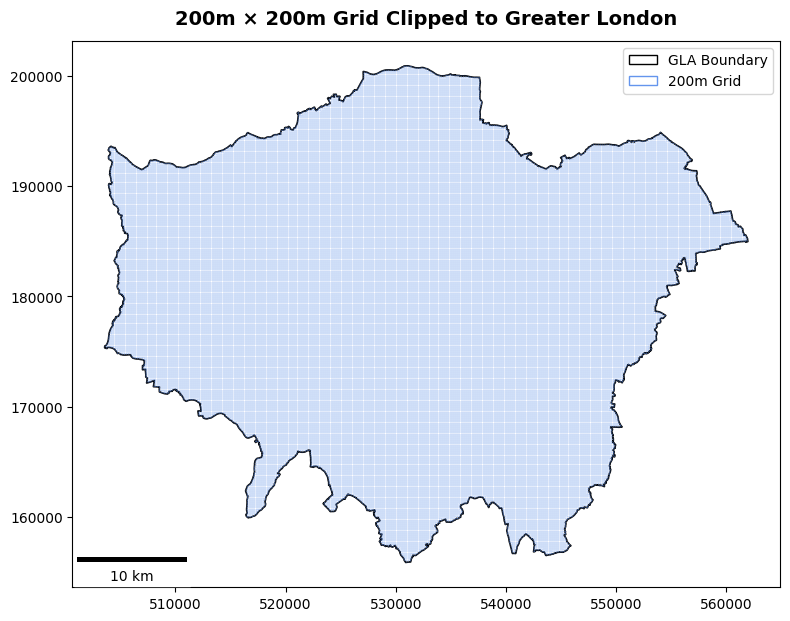

In [163]:
# Visual check: Grid overlaid on official boundary
# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Plot Greater London boundary and grid
gla_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.2)
grid_200m.plot(ax=ax, facecolor='none', edgecolor='cornflowerblue', linewidth=0.2, alpha=0.6)

# Add title
ax.set_title("200m × 200m Grid Clipped to Greater London", fontsize=14, fontweight='bold', pad=12)

# Manually define legend handles
legend_elements = [
    Patch(facecolor='none', edgecolor='black', label='GLA Boundary'),
    Patch(facecolor='none', edgecolor='cornflowerblue', label='200m Grid')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Add scalebar
scalebar = ScaleBar(1, units="m", dimension="si-length", location="lower left")
ax.add_artist(scalebar)

# Set aspect and axis style
ax.set_aspect('equal')
ax.tick_params(axis='both', labelsize=10)

# Final layout adjustment
plt.tight_layout()
plt.show()

In [164]:
# Save Grid File
grid_200m.to_file("data/London_boundary/Grid_200m_London.geojson", driver="GeoJSON")

#### Crime Data Preparation

##### Burglary Data Selection and Aggregation

Burglary data from the Metropolitan Police Service (MPS) was used as the target variable. It includes two types: - **Burglary in a Dwelling**
(residential burglary) - **Burglary Business and Community** (non-residential burglary)

Monthly data from January to December 2019 were aggregated at the LSOA level, avoiding
pandemic-related distortions.

Burglary data from the Metropolitan Police Service (MPS) was used as the target variable. It includes two types:
- **Burglary in a Dwelling** (residential burglary)
- **Burglary Business and Community** (non-residential burglary)

Monthly data from January to December 2019 were aggregated at the LSOA level, avoiding pandemic-related distortions.

In [165]:
# Load the historic MPS crime dataset
crime_df = pd.read_csv("data/London_crime/MPS LSOA Level Crime (Historical).csv")

# Display the first few rows and column names for structure verification
print("Column names:", crime_df.columns)
crime_df.head()

Column names: Index(['LSOA Code', 'LSOA Name', 'Borough', 'Major Category', 'Minor Category',
       '201903', '201904', '201905', '201906', '201907',
       ...
       '202206', '202207', '202208', '202209', '202210', '202211', '202212',
       '202301', '202302', '202303'],
      dtype='object', length=161)


,LSOA Code,LSOA Name,Borough,Major Category,Minor Category,201903,201904,201905,201906,201907,...,202206,202207,202208,202209,202210,202211,202212,202301,202302,202303
0,E01000006,Barking and Dagenham 016A,E09000002,ARSON AND CRIMINAL DAMAGE,ARSON,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,E01000006,Barking and Dagenham 016A,E09000002,ARSON AND CRIMINAL DAMAGE,CRIMINAL DAMAGE,1,2,0,1,0,...,0,2,1,0,0,0,0,0,0,1
2,E01000006,Barking and Dagenham 016A,E09000002,BURGLARY,BURGLARY BUSINESS AND COMMUNITY,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,E01000006,Barking and Dagenham 016A,E09000002,BURGLARY,BURGLARY IN A DWELLING,1,0,3,1,0,...,0,0,0,0,0,2,0,0,0,0
4,E01000006,Barking and Dagenham 016A,E09000002,DRUG OFFENCES,POSSESSION OF DRUGS,2,2,0,0,0,...,0,0,1,0,4,1,0,0,0,0


In [166]:
# Define burglary categories based on actual values in the dataset
target_minor = ['BURGLARY BUSINESS AND COMMUNITY', 'BURGLARY IN A DWELLING']

# Filter to keep only those rows matching burglary categories
crime_burglary = crime_df[
    (crime_df["Major Category"] == "BURGLARY") &
    (crime_df["Minor Category"].isin(target_minor))
]

In [ ]:
# Define list of column names corresponding to each month in 2019
months_2019 = [f"2019{str(m).zfill(2)}" for m in range(1, 13)]

# Ensure all required columns exist
assert all(col in crime_burglary.columns for col in months_2019), "Some 2019 columns missing"

# Sum across all 2019 months to obtain total burglary counts
crime_burglary["burglary_total_2019"] = crime_burglary[months_2019].sum(axis=1)

In [168]:
# Group by LSOA and sum across both residential + business categories
burglary_lsoa = (
    crime_burglary
    .groupby("LSOA Code")["burglary_total_2019"]
    .sum()
    .reset_index()
    .rename(columns={"LSOA Code": "LSOA_code"})
)

# Check output
print(f"Number of LSOAs with burglary data: {len(burglary_lsoa)}")
burglary_lsoa.head()

Number of LSOAs with burglary data: 4988


,LSOA_code,burglary_total_2019
0,E01000006,13
1,E01000007,20
2,E01000008,17
3,E01000009,14
4,E01000011,4


##### Spatial Interpolation to Grid Resolution

Aggregated LSOA-level burglary data were converted into a continuous surface using inverse distance weighted (IDW) interpolation. The centroid of each LSOA polygon served as the input point, and values were estimated at the centroids of 200 m × 200 m grid cells. 

In [169]:
# Load LSOA shapefile and convert to British National Grid
lsoa_gdf = gpd.read_file("data/London_LSOA_2011/LSOA_2011_London_gen_MHW.shp")
lsoa_gdf = lsoa_gdf.to_crs(epsg=27700)

# Merge burglary totals into LSOA GeoDataFrame
lsoa_gdf = lsoa_gdf.merge(burglary_lsoa, how="left", left_on="LSOA11CD", right_on="LSOA_code")

# Drop rows without burglary data (optional)
lsoa_gdf = lsoa_gdf.dropna(subset=["burglary_total_2019"])

In [170]:
# Use centroids of LSOAs as interpolation points
lsoa_points = lsoa_gdf.copy()
lsoa_points["geometry"] = lsoa_points.centroid

In [171]:
# Prepare grid centroids for interpolation targets
# Load the 200m grid you previously created
grid = gpd.read_file("data/London_boundary/Grid_200m_London.geojson")

# Compute centroids of each grid cell (for interpolation)
grid["centroid"] = grid.centroid
grid_points = pd.DataFrame({
    "x": grid["centroid"].x,
    "y": grid["centroid"].y
})

In [172]:
# Perform IDW interpolation
def idw_interpolation(xy_known, values_known, xy_targets, k=8, power=2):
    tree = cKDTree(xy_known)
    dists, idxs = tree.query(xy_targets, k=k)
    
    # Avoid division by zero
    dists = np.where(dists == 0, 1e-10, dists)
    weights = 1 / dists ** power
    
    values = np.sum(weights * values_known[idxs], axis=1) / np.sum(weights, axis=1)
    return values

In [173]:
# Prepare coordinates and values for IDW
xy_known = np.array(list(zip(lsoa_points.geometry.x, lsoa_points.geometry.y)))
values_known = lsoa_points["burglary_total_2019"].values
xy_targets = np.array(list(zip(grid_points["x"], grid_points["y"])))

# Run IDW interpolation
grid["burglary_idw_2019"] = idw_interpolation(xy_known, values_known, xy_targets)

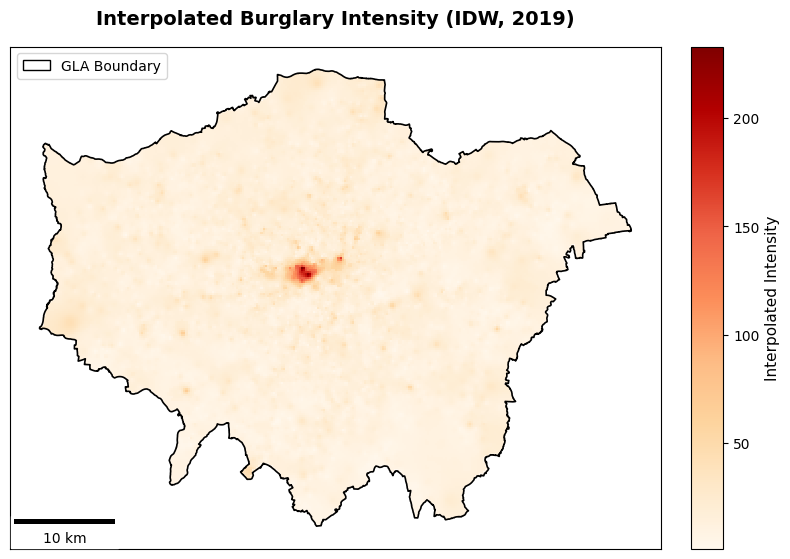

In [174]:
# Visual check: IDW result
# Create figure and main axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot IDW result
main_plot = grid.plot(
    column="burglary_idw_2019",
    cmap="OrRd",
    ax=ax,
    edgecolor="none"
)

# Overlay GLA boundary
gla_boundary.plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
    linewidth=1.2
)

# Title
ax.set_title(
    "Interpolated Burglary Intensity (IDW, 2019)",
    fontsize=14,
    fontweight="bold",
    pad=16
)

# Hide ticks, keep spatial proportions
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

# Add scale bar
scalebar = ScaleBar(1, units="m", dimension="si-length", location="lower left")
ax.add_artist(scalebar)

# Add manual legend for boundary
legend_elements = [
    Patch(facecolor='none', edgecolor='black', label='GLA Boundary')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Create divider for colourbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)

# Add colourbar
sm = plt.cm.ScalarMappable(
    cmap="OrRd",
    norm=plt.Normalize(
        vmin=grid["burglary_idw_2019"].min(),
        vmax=grid["burglary_idw_2019"].max()
    )
)
sm._A = []
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("Interpolated Intensity", fontsize=11)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

##### Standardisation of Burglary Density

To enable spatial comparability and predictive modelling, interpolated values were normalised by dividing each grid estimate by the cell area (0.04 km²), yielding burglary density per square kilometre. 

In [175]:
# Standardisation: calculation of burglary density per square kilometre
grid["burglary_density_per_km2"] = grid["burglary_idw_2019"] / 0.04

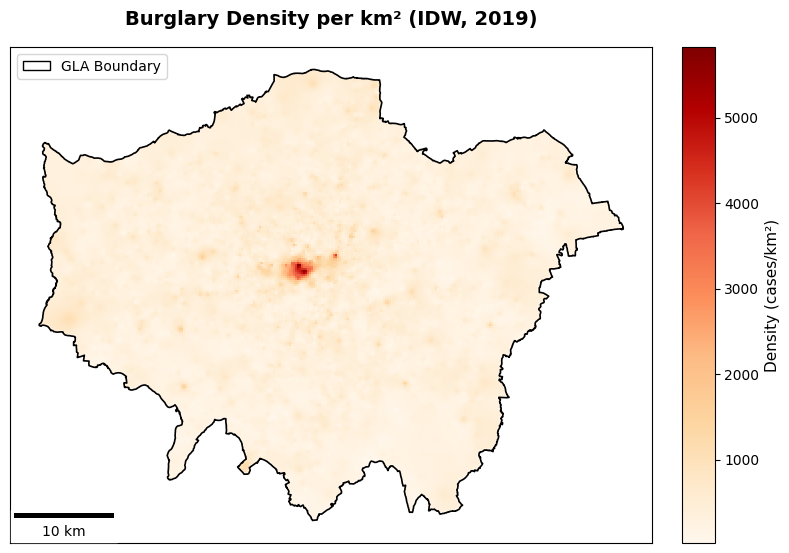

In [176]:
# Visual check: Standardisation result
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot standardised burglary density
grid.plot(
    column="burglary_density_per_km2",
    cmap="OrRd",
    ax=ax,
    edgecolor="none"
)

# Overlay GLA boundary
gla_boundary.plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
    linewidth=1.2
)

# Set title with unified style
ax.set_title(
    "Burglary Density per km² (IDW, 2019)",
    fontsize=14,
    fontweight="bold",
    pad=16
)

# Hide tick labels and enforce aspect
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

# Add scale bar
scalebar = ScaleBar(1, units="m", dimension="si-length", location="lower left")
ax.add_artist(scalebar)

# Add manual legend for boundary
legend_elements = [
    Patch(facecolor='none', edgecolor='black', label='GLA Boundary')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

# Create colourbar next to the main plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)

# Add colourbar manually
sm = plt.cm.ScalarMappable(
    cmap="OrRd",
    norm=plt.Normalize(
        vmin=grid["burglary_density_per_km2"].min(),
        vmax=grid["burglary_density_per_km2"].max()
    )
)
sm._A = []
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("Density (cases/km²)", fontsize=11)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

In [177]:
# Drop all columns that contain shapely geometries, except the main 'geometry' column
from shapely.geometry.base import BaseGeometry

cols_to_drop = [
    col for col in grid.columns
    if col != "geometry" and grid[col].apply(lambda x: isinstance(x, BaseGeometry)).any()
]

grid = grid.drop(columns=cols_to_drop)

In [178]:
# Save grid with burglary density per km²
grid.to_file("data/London_boundary/Grid_200m_burglary_density.geojson", driver="GeoJSON")

This spatial normalisation technique is commonly used in environmental criminology to support micro-risk mapping and has been validated in previous studies (e.g. Bediroglu & Colak, 2024; Povala et al., 2020; Wheeler & Steenbeek, 2021).

#### POI Data Extraction and Cleaning

Point of Interest (POI) data was extracted from OpenStreetMap using the OSMnx Python library. Categories were selected based on everyday activity theory and crime pattern theory, which emphasise how infrastructure and urban functions shape crime risk (Brantingham & Brantingham, 1995; Groff & McCord, 2012; Wheeler & Steenbeek, 2021).

Included categories were: ATMs, restaurants, pubs, shops, parks, bus stops, and railway/underground stations.Each represents potential attractors or generators due to economic value, footfall, or routine activity.

Data cleaning included deduplication, reprojection to EPSG:27700, and spatial clipping to the Greater London boundary. POIs were aggregated to 200 m × 200 m grid cells to serve as spatial predictors in the burglary model.

In [179]:
# Load the Greater London boundary and ensure correct coordinate system (British National Grid)
gla_boundary = gpd.read_file("data/London_boundary/London_GLA_Boundary.shp")
gla_boundary = gla_boundary.to_crs(epsg=27700)

In [180]:
# Define standard POI categories (excluding 'park' for now)
poi_tags = {
    'atm': {'amenity': 'atm'},
    'restaurant': {'amenity': 'restaurant'},
    'pub': {'amenity': 'pub'},
    'shop': {'shop': True},
    'bus_stop': {'highway': 'bus_stop'},
    'train_station': {'railway': 'station'},
    'subway_station': {'station': 'subway'}
}

# Initialise empty list to collect POI GeoDataFrames
poi_layers = []

# Loop through categories and download POIs
for label, tags in poi_tags.items():
    gla_polygon = gla_boundary.to_crs(epsg=4326).unary_union
    
    # Download features from OpenStreetMap
    pois = ox.features_from_polygon(gla_polygon, tags)
    pois = pois[pois.geometry.notnull()]
    pois = pois.to_crs(epsg=27700)
    
    # Retain only point features
    pois = pois[pois.geometry.geom_type == "Point"]
    
    # Create clean GeoDataFrame
    pois = pois[["geometry"]].copy()
    pois["category"] = label
    
    # Remove duplicates and clip to GLA boundary
    pois = pois.drop_duplicates(subset=["geometry"])
    pois = gpd.overlay(pois, gla_boundary, how="intersection")
    
    poi_layers.append(pois)

In [181]:
# Extract parks from multiple relevant OSM tags
park_tags = [
    {"leisure": "park"},
    {"landuse": "recreation_ground"},
    {"leisure": "garden"},
    {"leisure": "common"}
]

park_layers = []

for tag in park_tags:
    gla_polygon = gla_boundary.to_crs(epsg=4326).unary_union
    park = ox.features_from_polygon(gla_polygon, tag)
    park = park[park.geometry.notnull()]
    park = park.to_crs(epsg=27700)
    
    # Only keep point features
    park = park[park.geometry.geom_type == "Point"]
    park = park[["geometry"]].copy()
    park["category"] = "park"
    
    park = park.drop_duplicates(subset=["geometry"])

    # Reset index to avoid ValueError in overlay
    park = park.reset_index(drop=True)
    gla_boundary = gla_boundary.reset_index(drop=True)

    # Clip 'park' geometries to the GLA boundary
    park = gpd.overlay(park, gla_boundary, how="intersection")
    
    park_layers.append(park)

# Combine all 'park' types into one layer
parks_all = gpd.GeoDataFrame(pd.concat(park_layers, ignore_index=True), crs="EPSG:27700")

In [182]:
# Append parks and merge all POIs
poi_layers.append(parks_all)
poi_all = gpd.GeoDataFrame(pd.concat(poi_layers, ignore_index=True), crs="EPSG:27700")

# Print counts per category
print(poi_all["category"].value_counts())

category
shop              25539
bus_stop          19933
restaurant         5576
atm                1637
pub                1268
train_station       612
subway_station      260
park                 80
Name: count, dtype: int64


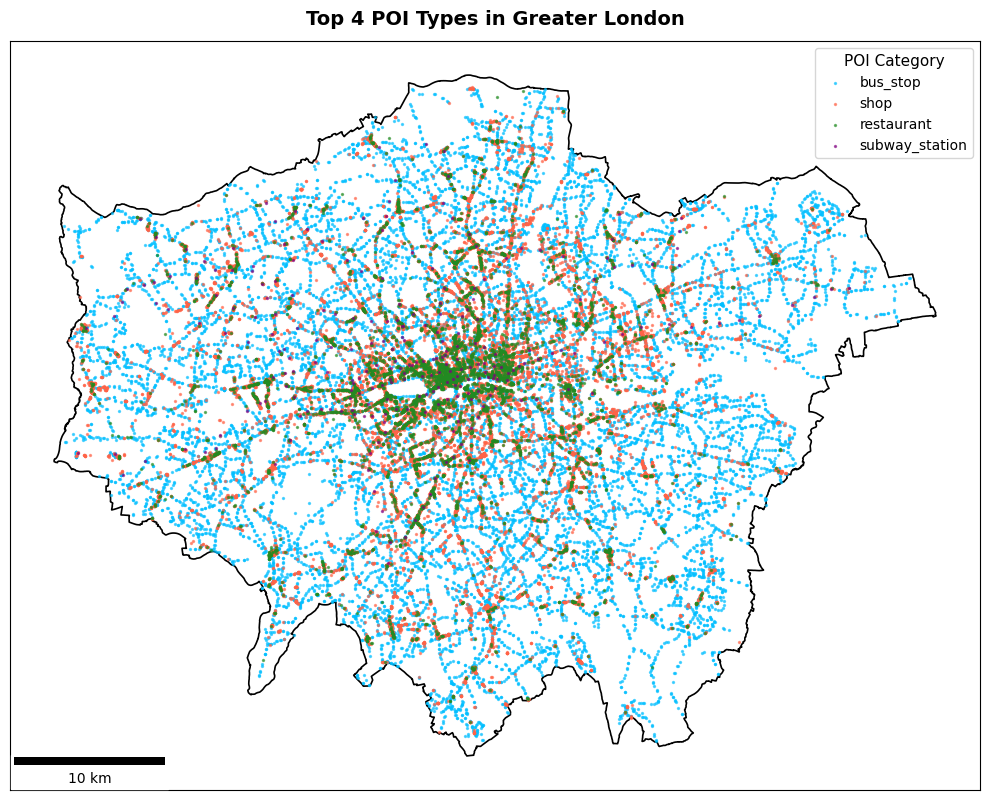

In [183]:
# Visual Check : POI Clean Result

# For the sake of visual clarity, only the four most frequent POI categories are displayed.
# Visualising all categories simultaneously would result in severe overplotting
# and hinder the interpretability of spatial patterns.

# Count frequency of POI categories
top_categories = poi_all['category'].value_counts().nlargest(4).index.tolist()

# Define new colour map
poi_colours_top = {
    'bus_stop': 'deepskyblue',
    'shop': 'tomato',
    'restaurant': 'forestgreen',
    'subway_station': 'purple'
}

# Filter
poi_subset = poi_all[poi_all['category'].isin(poi_colours_top.keys())]
poi_subset = poi_subset.to_crs(gla_boundary.crs)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gla_boundary.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.2)

for cat, colour in poi_colours_top.items():
    subset = poi_subset[poi_subset['category'] == cat]
    subset.plot(ax=ax, markersize=2, alpha=0.6, color=colour, label=cat)

ax.set_title(
    "Top 4 POI Types in Greater London",
    fontsize=14, fontweight='bold', pad=12
)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.legend(title="POI Category", loc='upper right', fontsize=10, title_fontsize=11)

# Scale bar
scalebar = ScaleBar(1, units="m", dimension="si-length", location="lower left")
ax.add_artist(scalebar)

plt.tight_layout()
plt.show()

In [184]:
# Save POI Files
poi_all.to_file("data/POI/POI_All_Cleaned.geojson", driver="GeoJSON")

#### POI Aggregation to Grid

Cleaned POI data were aggregated to 200 m × 200 m grid cells by counting the number of points per category in each cell. This produced spatial features aligned with burglary density, capturing micro-scale variations in urban amenities for use in regression or machine learning models.

In [185]:
poi_all = gpd.read_file("data/POI/POI_All_Cleaned.geojson")

In [186]:
# Load and reset grid
grid = gpd.read_file("data/London_boundary/Grid_200m_burglary_density.geojson")
grid = grid.reset_index(drop=True) 

# Copy clean grid for storing feature values
grid_features = grid.copy()

# Ensure CRS is aligned
assert poi_all.crs == grid.crs

# Loop over POI categories and aggregate counts into grid cells
for category in poi_all['category'].unique():
    pois_cat = poi_all[poi_all["category"] == category]
    
    # Spatial join: assign POIs to grid cells
    joined = gpd.sjoin(pois_cat, grid, how="left", predicate="within")
    
    # Count how many POIs fall into each grid cell
    count_series = joined["index_right"].value_counts()
    
    # Assign counts to grid_features (missing values are filled as 0)
    grid_features[category + "_count"] = grid_features.index.map(count_series).fillna(0).astype(int)

# Quick check
grid_features[[col for col in grid_features.columns if col.endswith("_count")]].describe()

,atm_count,restaurant_count,pub_count,shop_count,bus_stop_count,train_station_count,subway_station_count,park_count
count,40626.000000,40626.000000,40626.000000,40626.000000,40626.000000,40626.000000,40626.000000,40626.000000
mean,0.040294,0.137252,0.031212,0.628637,0.490646,0.015064,0.006400,0.001969
std,0.275839,0.823930,0.208049,3.037320,0.941814,0.124013,0.080052,0.055657
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,11.000000,29.000000,7.000000,80.000000,18.000000,2.000000,2.000000,5.000000


#### Feature Engineering

POI counts (e.g., shops, parks, transport nodes) were aggregated for each grid cell to characterise the local built environment. The study also calculated the Euclidean distance from each cell to the nearest burglary hotspot (top 20 cells with the highest density). All explanatory variables were standardised using Z-score transformation to improve comparability. The target variable, burglary density per km², was kept in its original scale. Geometries were preserved for spatial post-analysis.

| Variable                     | Description                                 |
|-----------------------------|---------------------------------------------|
| atm_count                   | Number of ATMs                              |
| restaurant_count            | Number of restaurants                       |
| pub_count                   | Number of pubs                              |
| shop_count                  | Number of retail shops                      |
| bus_stop_count              | Number of bus stops                         |
| train_station_count         | Number of train stations                    |
| subway_station_count        | Number of underground stations              |
| park_count                  | Number of parks                             |
| dist_to_burglary_hotspot    | Distance to nearest burglary hotspot        |
| burglary_density_per_km2    | Burglary cases per square km (target)       |

In [187]:
# --- Identify burglary hotspots from grid_features ---

# Copy target variables from grid to grid_features
grid_features["burglary_density_per_km2"] = grid["burglary_density_per_km2"]

In [188]:
# Define number of hotspot cells to retain
top_n = 20

# Sort grid cells by interpolated burglary density (descending order)
# Assumes 'burglary_density_per_km2' already exists in grid_features
top_grids = grid_features.sort_values("burglary_density_per_km2", ascending=False).head(top_n).copy()

# Convert hotspot cells to their centroid points
top_grids["geometry"] = top_grids.geometry.centroid

# Construct GeoDataFrame containing hotspot points
hotpoints_gdf = gpd.GeoDataFrame(top_grids[["geometry"]], crs=grid_features.crs)

# --- Calculate distance to nearest hotspot for each grid cell ---

# Compute centroids of all grid cells (as query points)
grid_features["centroid"] = grid_features.geometry.centroid

# Extract coordinates as numpy arrays
grid_coords = np.array([(geom.x, geom.y) for geom in grid_features.centroid])
hotpoint_coords = np.array([(geom.x, geom.y) for geom in hotpoints_gdf.geometry])

# Build KDTree for efficient nearest-neighbour search
tree = cKDTree(hotpoint_coords)
distances, _ = tree.query(grid_coords, k=1)

# Add distance as new feature to grid_features
grid_features["dist_to_burglary_hotspot"] = distances

# Remove temporary centroid column
grid_features = grid_features.drop(columns="centroid")

# --- Quick check on new variable ---
print(grid_features["dist_to_burglary_hotspot"].describe())


count    40626.000000
mean     15321.418659
std       6205.446111
min          0.000000
25%      10897.706181
50%      15606.408940
75%      19832.296892
max      31859.987370
Name: dist_to_burglary_hotspot, dtype: float64


In [189]:
# --- Calculate distance to nearest burglary hotspot ---

# Extract coordinates of hotspot centroids (assumed to be in a GeoDataFrame)
hotpoints_coords = np.array([(pt.x, pt.y) for pt in hotpoints_gdf.geometry])

# Calculate centroids of each grid cell
grid_features["centroid"] = grid_features.geometry.centroid
grid_coords = np.array([(pt.x, pt.y) for pt in grid_features.centroid])

# Build KDTree and compute nearest distance from each grid cell to a hotspot
tree = cKDTree(hotpoints_coords)
distances, _ = tree.query(grid_coords, k=1)

# Add the distance as a new spatial feature
grid_features["dist_to_burglary_hotspot"] = distances

# Remove temporary centroid column
grid_features = grid_features.drop(columns="centroid")

# --- Assign target variable ---

# Copy burglary density (per km²) from grid to feature table
grid_features["burglary_density_per_km2"] = grid["burglary_density_per_km2"]

# --- Define explanatory variables ---

# Include POI-based counts and spatial proximity to hotspots
poi_columns = [
    "atm_count", "restaurant_count", "pub_count", "shop_count",
    "bus_stop_count", "train_station_count", "subway_station_count", "park_count",
    "dist_to_burglary_hotspot"
]

# Create feature matrix (X) and target vector (y)
X = grid_features[poi_columns]
y = grid_features["burglary_density_per_km2"]

# --- Standardise features using Z-score ---

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled array back to DataFrame for further use
X_scaled_df = pd.DataFrame(X_scaled, columns=poi_columns, index=grid_features.index)

# --- Combine X and y into final modelling DataFrame ---

model_df = pd.concat([X_scaled_df, y], axis=1)

# Preview the resulting table
print(model_df.head())

   atm_count  restaurant_count  pub_count  shop_count  bus_stop_count  \
0  -0.146081         -0.166584  -0.150022   -0.206973       -0.520965   
1  -0.146081         -0.166584  -0.150022   -0.206973       -0.520965   
2  -0.146081         -0.166584  -0.150022   -0.206973       -0.520965   
3  -0.146081         -0.166584  -0.150022   -0.206973       -0.520965   
4  -0.146081         -0.166584  -0.150022   -0.206973       -0.520965   

   train_station_count  subway_station_count  park_count  \
0            -0.121475             -0.079947   -0.035381   
1            -0.121475             -0.079947   -0.035381   
2            -0.121475             -0.079947   -0.035381   
3            -0.121475             -0.079947   -0.035381   
4            -0.121475             -0.079947   -0.035381   

   dist_to_burglary_hotspot  burglary_density_per_km2  
0                  1.751735                660.888761  
1                  1.743859                646.925410  
2                  1.728224     

In [190]:
# Save Features File
grid_features.to_file("data/ml_model/Grid_features_for_model.geojson", driver="GeoJSON")

## Methodology

[[ go back to the top ]](#Table-of-contents)

### Flowchart 

The following methodological workflow summarises the entire analytical process, including the preprocessing steps discussed above and the subsequent modelling and interpretation phases.

The workflow of this analysis is summarised in the flowchart below:

![alt text](flowchart/CASA0006_assessment_flowchart.drawio.png)

### Model Selection and Setup

This study adopted an XGBoost Regressor to model burglary density using POI counts and distance to hotspots as features. XGBoost was chosen for its ability to model non-linear relationships and support SHAP-based interpretation. Due to the right-skewed distribution of the target variable, a `log1p` transformation was applied to stabilise variance and support generalisation.

In [191]:
# --- Model Selection and Setup ---

# Load the GeoDataFrame containing standardised POI features and burglary density
grid_features = gpd.read_file("data/ml_model/Grid_features_for_model.geojson")

Training set: 32500 samples
Testing set: 8126 samples


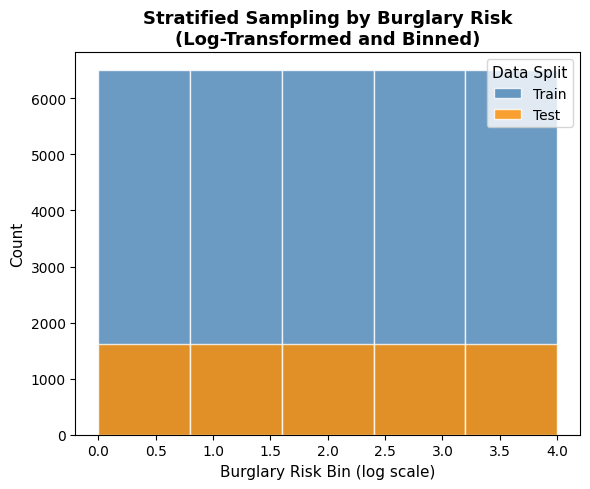

In [192]:
# Define feature columns: POIs + distance to burglary hotspot
poi_columns = [
    "atm_count", "restaurant_count", "pub_count", "shop_count",
    "bus_stop_count", "train_station_count", "subway_station_count", "park_count"
]
feature_columns = poi_columns + ["dist_to_burglary_hotspot"]

# Define feature matrix X and target y
X = model_df[feature_columns]
y = model_df["burglary_density_per_km2"]

# Log-transform target variable to reduce skewness
y_log = np.log1p(y)  # log(1 + y) to avoid log(0)

# Standardise features (z-score normalisation)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns, index=model_df.index)

# Bin target variable for stratified sampling
y_binned = pd.qcut(y_log, q=5, labels=False, duplicates="drop")

# Split data using stratified sampling
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in splitter.split(X_scaled_df, y_binned):
    X_train, X_test = X_scaled_df.iloc[train_idx], X_scaled_df.iloc[test_idx]
    y_train, y_test = y_log.iloc[train_idx], y_log.iloc[test_idx]

# Print outcome
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Visualise the stratified bins
# Create histogram with improved style
plt.figure(figsize=(6, 5))
plt.hist(
    y_binned[train_idx],
    bins=5,
    alpha=0.8,
    label="Train",
    color="steelblue",
    edgecolor="white"
)
plt.hist(
    y_binned[test_idx],
    bins=5,
    alpha=0.8,
    label="Test",
    color="darkorange",
    edgecolor="white"
)

# Title and labels
plt.title("Stratified Sampling by Burglary Risk\n(Log-Transformed and Binned)", fontsize=13, fontweight='bold')
plt.xlabel("Burglary Risk Bin (log scale)", fontsize=11)
plt.ylabel("Count", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Data Split", fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()

In [193]:
# Train/Test bin count
print("Train bin distribution:")
print(np.bincount(y_binned[train_idx]))
print("Test bin distribution:")
print(np.bincount(y_binned[test_idx]))

Train bin distribution:
[6500 6500 6500 6500 6500]
Test bin distribution:
[1626 1625 1625 1625 1625]


### XGBoost Training

The dataset was split using stratified sampling (80:20) based on quantiles of log-transformed burglary density. The model was configured with moderate depth (`max_depth=4`, `n_estimators=100`) and regularisation (`subsample=0.8`). It achieved an R² of 0.195 on the test set—modest, but within acceptable range for spatial crime modelling.


R² score: 0.195
RMSE: 0.38


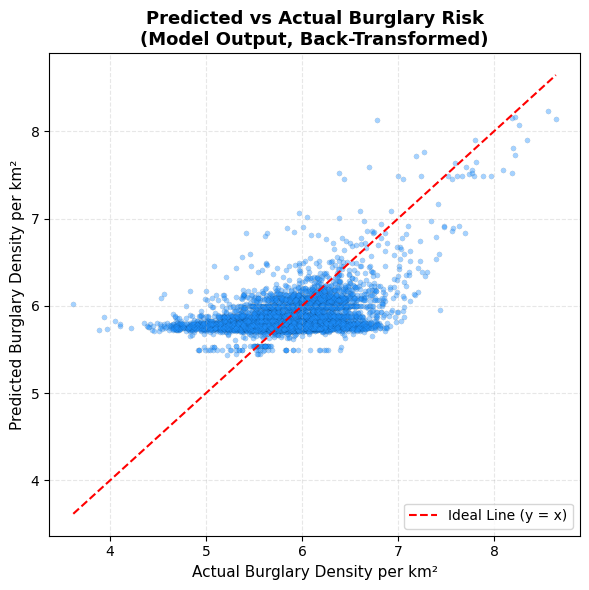

In [194]:
# Prepare log-transformed target variable
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# Train the XGBoost Regressor
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train_log)

# Predict on test set
y_pred_log = model.predict(X_test)

# Back-transform predictions and actual values to original scale
y_pred = np.exp(y_pred_log)
y_true = np.exp(y_test_log)

# Evaluate model performance
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"R² score: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")

# Scatter plot of prediction vs actual

# Create scatter plot of predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(
    y_true, y_pred,
    alpha=0.4,
    s=14,
    edgecolor='k',
    linewidth=0.1,
    color='dodgerblue'
)

# Plot ideal reference line (y = x)
plt.plot(
    [y_true.min(), y_true.max()],
    [y_true.min(), y_true.max()],
    linestyle='--',
    color='red',
    linewidth=1.5,
    label='Ideal Line (y = x)'
)

# Set axis labels
plt.xlabel("Actual Burglary Density per km²", fontsize=11)
plt.ylabel("Predicted Burglary Density per km²", fontsize=11)

# Set title
plt.title("Predicted vs Actual Burglary Risk\n(Model Output, Back-Transformed)", fontsize=13, fontweight='bold')

# Add legend and grid
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### SHAP Analysis for Feature Importance

SHAP analysis revealed that distance to prior hotspots had the strongest influence on predicted risk. Among POI variables, restaurants, shops, and bus stops were more predictive than rail-based transport nodes, highlighting burglary’s association with everyday commercial and pedestrian activity.

In [195]:
# Construct SHAP explainer (compatible with XGBoost Booster)
explainer = shap.Explainer(model, X_train, feature_names=X_train.columns)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

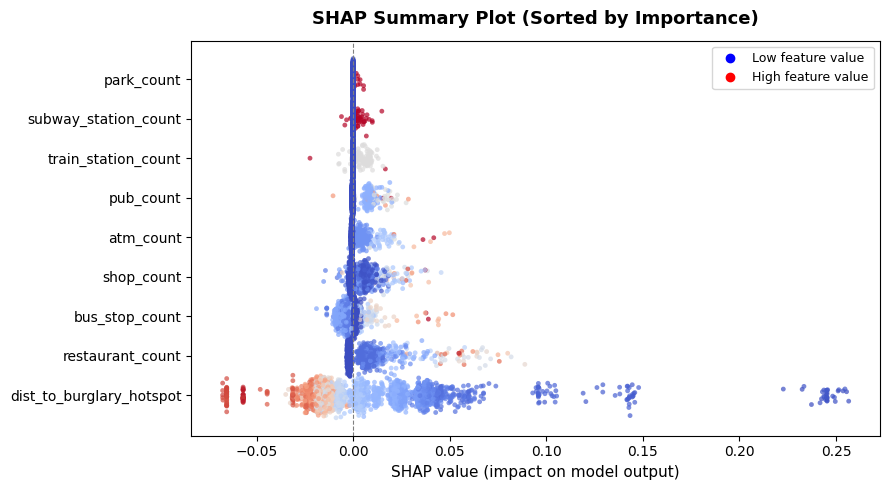

In [196]:
# Compute mean absolute SHAP value for each feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
sorted_idx = np.argsort(mean_abs_shap)[::-1]
sorted_features = X_test.columns[sorted_idx]

# Extract sorted values
shap_vals_sorted = shap_values.values[:, sorted_idx]
feature_vals_sorted = X_test[sorted_features]

# Prepare figure and axis
fig, ax = plt.subplots(figsize=(9, 5))
y_positions = np.arange(len(sorted_features))

# Plot beeswarm (no bars)
for i, feature in enumerate(sorted_features):
    shap_vals = shap_vals_sorted[:, i]
    feat_vals = feature_vals_sorted[feature].values

    normed = (feat_vals - feat_vals.min()) / (feat_vals.max() - feat_vals.min())
    colours = plt.cm.coolwarm(normed)

    jitter = np.random.normal(0, 0.15, size=len(shap_vals))
    ax.scatter(
        shap_vals,
        np.full_like(shap_vals, y_positions[i]) + jitter,
        color=colours,
        s=12,
        alpha=0.7,
        edgecolors='none'
    )

# Label and legend
ax.set_yticks(y_positions)
ax.set_yticklabels(sorted_features, fontsize=10)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=11)
ax.set_title("SHAP Summary Plot (Sorted by Importance)", fontsize=13, fontweight='bold', pad=12)
ax.axvline(x=0, color='grey', linewidth=0.8, linestyle='--')

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='blue', label='Low feature value',
           markersize=6, linestyle='None'),
    Line2D([0], [0], marker='o', color='red', label='High feature value',
           markersize=6, linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9)

# Layout
plt.tight_layout()
plt.show()

### KDE Hotspot Identification

Kernel Density Estimation (KDE) was applied using the centroids of grid cells with non-zero burglary risk. The KDE surface revealed a concentrated hotspot in central London, especially Westminster, closely overlapping with the top-ranked cells predicted by the model.

In [197]:
# Filter grid cells with non-zero burglary density and compute centroids
burglary_cells = grid_features[grid_features["burglary_density_per_km2"] > 0].copy()
burglary_cells["centroid"] = burglary_cells.geometry.centroid

# Extract centroid coordinates
coords = np.array([(geom.x, geom.y) for geom in burglary_cells["centroid"]])
x, y = coords[:, 0], coords[:, 1]

# Apply 2D Kernel Density Estimation
kde = gaussian_kde(np.vstack([x, y]))

# Generate grid for density evaluation
xmin, ymin, xmax, ymax = grid_features.total_bounds
xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
positions = np.vstack([xx.ravel(), yy.ravel()])
kde_values = np.reshape(kde(positions).T, xx.shape)

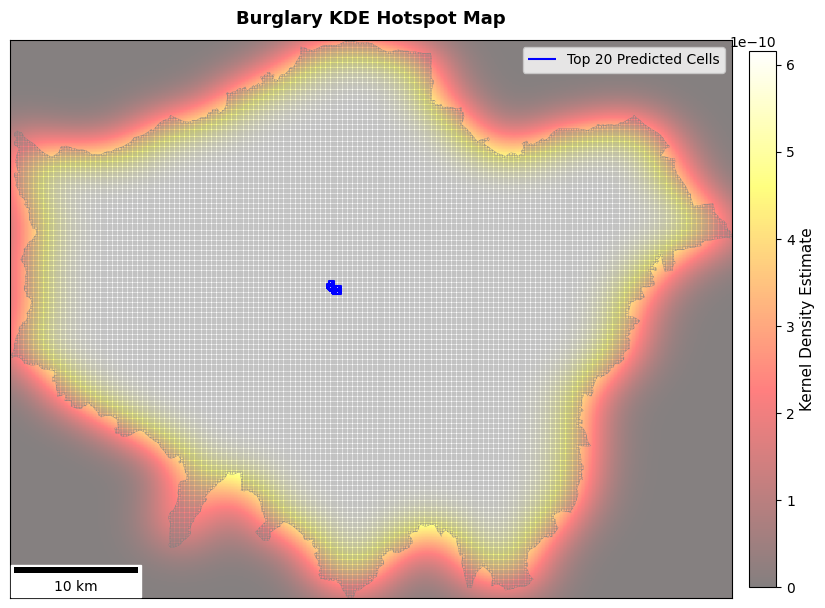

In [198]:
# KDE hotspot map visualisation
fig, ax = plt.subplots(figsize=(9, 7))

# Title with consistent style
ax.set_title("Burglary KDE Hotspot Map", fontsize=13, fontweight='bold', pad=12)

# Plot KDE raster layer
heat = ax.imshow(
    kde_values.T,
    extent=(xmin, xmax, ymin, ymax),
    origin="lower",
    cmap="hot",
    alpha=0.5
)

# Overlay all grid boundaries
grid_features.boundary.plot(ax=ax, linewidth=0.2, color='grey')

# Identify top 20 cells by burglary density and plot their boundaries
top_pred_cells = burglary_cells.sort_values("burglary_density_per_km2", ascending=False).head(20)
top_pred_cells.geometry.boundary.plot(
    ax=ax,
    edgecolor="blue",
    linewidth=1.5,
    label="Top 20 Predicted Cells"
)

# Add KDE colourbar
cbar = plt.colorbar(heat, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label("Kernel Density Estimate", fontsize=11)
cbar.ax.tick_params(labelsize=10)

# Add legend
ax.legend(loc='upper right', fontsize=10)

# Add scale bar
scalebar = ScaleBar(1, units="m", location="lower left", dimension="si-length")
ax.add_artist(scalebar)

# Axis clean-up
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

### Residual Mapping

Residual analysis compared the actual and predicted burglary risk. The map showed that the model tended to underestimate risk in central boroughs and overestimate it in peripheral areas, indicating unmodelled spatial heterogeneity and the limits of POI-only predictors.

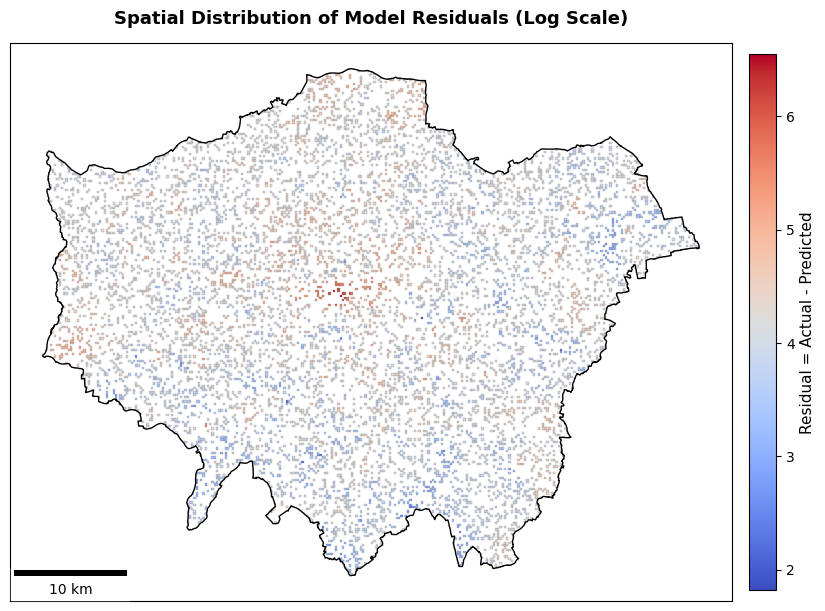

In [199]:
# Compute residuals
residuals = y_test - model.predict(X_test)

# Merge with geometry
test_index = X_test.index
residual_gdf = grid_features.loc[test_index].copy()
residual_gdf["residual"] = residuals

# Plot residuals spatially
fig, ax = plt.subplots(figsize=(9, 7))
ax.set_title("Spatial Distribution of Model Residuals (Log Scale)", fontsize=13, fontweight='bold', y=1.02)

# Plot residuals with diverging colour map
residual_plot = residual_gdf.plot(
    column="residual",
    cmap="coolwarm",
    edgecolor="grey",
    linewidth=0.2,
    ax=ax,
    legend=False
)

# Add Greater London boundary
gla_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Add colourbar manually
sm = plt.cm.ScalarMappable(
    cmap="coolwarm",
    norm=plt.Normalize(vmin=residual_gdf["residual"].min(), vmax=residual_gdf["residual"].max())
)
sm._A = []  # Dummy array for colorbar
cbar = fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label("Residual = Actual - Predicted", fontsize=11)
cbar.ax.tick_params(labelsize=10)

# Add scale bar
scalebar = ScaleBar(1, units="m", location="lower left", dimension="si-length")
ax.add_artist(scalebar)

# Clean axes
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [ ]:
end_time = time.time()  # Record the ending time of notebook execution
runtime_hours = (end_time - start_time) / 3600  # Convert runtime from seconds to hours
print(f"Total runtime: {runtime_hours:.2f} hours")  # Output the total runtime in hours

Total runtime: 0.04 hours


## Results and discussion

[[ go back to the top ]](#Table-of-contents)

The modelling results clearly answer the research questions. Firstly, the SHAP analysis showed that distance to existing burglary hotspots had the greatest impact on predicting burglary risk, supporting the concept of spatial inertia in crime. Among the POI features, restaurants, shops, and bus stops were the most predictive, suggesting a consistent association between burglary and areas with high pedestrian density and commercial activity. In contrast, rail nodes such as railway and metro stations had relatively low SHAP values, implying a weaker or more dispersed impact.

These results support established theories about crime attractors and generators (Brantingham & Brantingham, 1995). Commercial areas with longer hours of operation, high foot traffic and public activity appear to provide more opportunities for burglary. This aligns with the findings of Bernasco & Block (2011), who viewed concentrated commercial areas as high-risk environments, and Groff & McCord (2012), who explored how public activity spaces influence local crime risk.

Parks were a poorly explained category within the POI categories. Although parks are theoretically expected to be a trigger for crime, the variable `park_count` contributes little to the model's predictions. This may be partly due to data sparsity: OpenStreetMap's POI data tends to capture large formal parks, while smaller neighbourhood parks, gardens, or informal green spaces (which may have greater crime potential) are often underrepresented or inconsistently labelled. As a result, empirical signals may not fully reflect the theoretical significance of such urban spaces.

Kernel Density Estimation (KDE) is used to benchmark the spatial predictions.The KDE surface shows significant clustering in central London, with Westminster emerging as the main hotspot. These areas also rank highest in the XGBoost predictions, indicating strong spatial consistency.

Residual mapping shows that risk is underestimated in central areas and overestimated in peripheral wards. This pattern suggests the presence of unobserved spatial heterogeneity, such as housing type, local guardianship or socio-economic status - factors that cannot be captured by POI features alone (Povala et al., 2020; Sampson et al., 1997).

Overall, the combination of SHAP, KDE and residual analyses provides a nuanced understanding of the relationship between specific urban characteristics and burglary risk. Even with moderate R² values, the model provides meaningful spatial insight into the relationship between crime and the environment in London.

## Conclusion

[[ go back to the top ]](#Table-of-contents)

This study applied interpretable spatial machine learning to examine POI influences on burglary hotspots in London. SHAP analysis identified distance to existing hotspots as the strongest predictor, followed by commercial POIs such as restaurants and shops, and high-frequency surface transport POIs such as bus stops, highlighting associations between burglary risk, pedestrian activity, and urban functions.

The findings support theories of crime attractors and generators. KDE confirmed central clustering, while residual mapping revealed underpredicted risk in dense areas, suggesting unobserved socio-spatial factors.

Despite the moderate R² values and limited data, the method demonstrates the value of combining open city data with interpretable models for spatial crime analysis and informed urban safety planning. Future research could incorporate temporal patterns and socioeconomic variables to capture broader contextual influences.

## References

[[ go back to the top ]](#Table-of-contents)

- **Wheeler and Steenbeek (2021)**  
  Wheeler, A.P. and Steenbeek, W. (2021). Mapping the Risk Terrain for Crime Using Machine Learning. *Journal of Quantitative Criminology*, 37, pp.445–480. https://doi.org/10.1007/s10940-020-09457-7

- **Zhang et al. (2022)**  
  Zhang, X., Liu, L., Lan, M., Song, G., Xiao, L. and Chen, J. (2022). Interpretable machine learning models for crime prediction. *Computers, Environment and Urban Systems*, 94, 101789. https://doi.org/10.1016/j.compenvurbsys.2022.101789

- **Bediroglu and Colak (2024)**  
  Bediroglu, G. and Colak, H.E. (2024). Predicting and analyzing crime—Environmental design relationship via GIS-based machine learning approach. *Transactions in GIS*, 28, pp.1377–1399. https://doi.org/10.1111/tgis.13195

- **Bernasco and Block (2011)**  
  Bernasco, W. and Block, R. (2011). Robberies in Chicago: A Block-Level Analysis of the Influence of Crime Generators, Crime Attractors, and Offender Anchor Points. *Journal of Research in Crime and Delinquency*, 48(1), pp.33–57. https://doi.org/10.1177/0022427810384135

- **Brantingham and Brantingham (1995)**  
  Brantingham, P. and Brantingham, P. (1995). Criminality of place: Crime generators and crime attractors. *European Journal on Criminal Policy and Research*, 3, pp.5–26.

- **Groff and McCord (2012)**  
  Groff, E. and McCord, E.S. (2012). The role of neighborhood parks as crime generators. *Security Journal*, 25(1), pp.1–24. https://doi.org/10.1057/sj.2011.1

- **Povala et al. (2020)**  
  Povala, J., Virtanen, S. and Girolami, M. (2020). Burglary in London: insights from statistical heterogeneous spatial point processes. *Journal of the Royal Statistical Society: Series C (Applied Statistics)*, 69(5), pp.1067–1090.

- **Sampson et al. (1997)**  
  Sampson, R.J., Raudenbush, S.W. and Earls, F. (1997). Neighborhoods and Violent Crime: A Multilevel Study of Collective Efficacy. *Science*, 277(5328), pp.918–924. https://doi.org/10.1126/science.277.5328.918
